In [2]:
import os
import sys
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)

from main import *
from jax import jit
from functools import partial
import time as tm
# Bi modules
bi = bee(platform='cpu')
print(bee.dist.normal(0,1, sample = True, shape=(1,), seed = 1))
BEE.net.mat_to_edgl(jnp.array([[1, 2, 3, 4],
                              [5, 6, 7, 8],
                              [9, 10, 11, 12],
                              [13, 14, 15, 16]]))
print(BEE.gaussian_process)
print(BEE.random_centered)

jax.local_device_count 32
[-0.11617041]
<function Mgaussian.gaussian_process at 0x7fc19b7e0040>
<PjitFunction of <function factors.random_centered at 0x7fc19b7d1bd0>>


In [2]:
from Mutils import Mgaussian, cov_GPL2
from jax.scipy.stats import norm
gaus = Mgaussian()

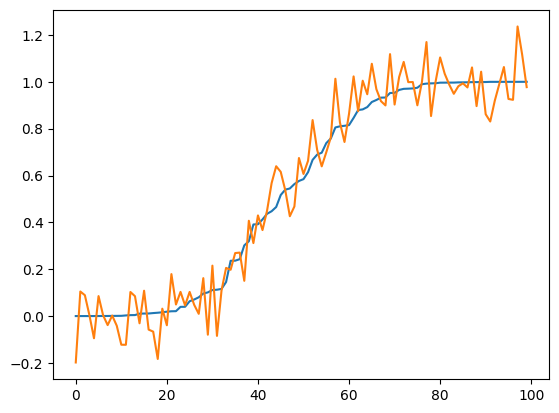

In [3]:
raw = sample.uniform(-4,4, sample_shape=(100,))
raw  = jnp.sort(raw)
sequence = jnp.array([i for i in range(1, 11) for _ in range(10)])
unique = jnp.unique(jnp.array(sequence))
result = []

for i in range(0,len(unique)):  
    result.append(jnp.mean(raw[jnp.where(sequence==(i + 1))], axis = 0))

Dmat = gaus.distance_matrix(jnp.array(result))
cdf_value = norm.cdf(raw , loc=0, scale=1)# to plot for after
plt.plot(jnp.arange(0, 100), cdf_value)
error = sample.normal(0, 0.1, sample_shape=(100,))
y = cdf_value + error
plt.plot(jnp.arange(0, 100), y)

In [7]:
def gaussian_process(Dmat, etasq, rhosq, sigmaq):
    SIGMA = cov_GPL2(Dmat, etasq, rhosq, sigmaq)
    L_SIGMA = jnp.linalg.cholesky(SIGMA)
    z = sample.normal(0, 1, sample_shape= (10,))
    k = numpyro.deterministic("k", (L_SIGMA @ z[..., None])[..., 0])
    return k

In [9]:
# Perform gaussain process through array of Nx3
a = sample.normal(0,1, (8, 20))
sigma = sample.exponential(1, sample_shape=(8*20,))
etasq = sample.exponential(2, sample_shape=(8*20,))
rhosq = sample.exponential(0.5, sample_shape=(8*20,))
sigmaq = sample.exponential(2, sample_shape= (8*20,))
tmp = jnp.stack([etasq, rhosq, sigmaq], axis = 1)
t = vmap(lambda x: gaussian_process(Dmat, x[0], x[1], x[2]))(tmp) # need to return 8 * 20 * 10
t.shape

(160, 10)

In [188]:
def gaus_model(Dmat, y ,sequence):
    a = dist.normal('a', 0,1)
    sigma = dist.exponential('s', 1)
    etasq = dist.exponential("etasq",2)
    rhosq = dist.exponential("rhosq",0.5)
    sigmaq = dist.exponential("sigmaq",2)

    SIGMA = cov_GPL2(Dmat, etasq, rhosq, sigmaq)
    L_SIGMA = jnp.linalg.cholesky(SIGMA)
    z = dist.normal('z', 0, 1, sample_shape= [10])
    k = numpyro.deterministic("k", (L_SIGMA @ z[..., None])[..., 0])
    
    mu = a + k[sequence]

    lk('Y', Normal(mu, sigma), obs=y)

dat = dict(
    Dmat = Dmat,
    y = y,
    sequence = sequence - 1 
)

m = MCMC(NUTS(gaus_model), num_warmup=500, num_samples=500, num_chains=1)
m.run(random.PRNGKey(0), **dat)
res = az.from_numpyro(m)


sample: 100%|██████████| 1000/1000 [03:53<00:00,  4.29it/s, 191 steps of size 2.40e-02. acc. prob=0.92]


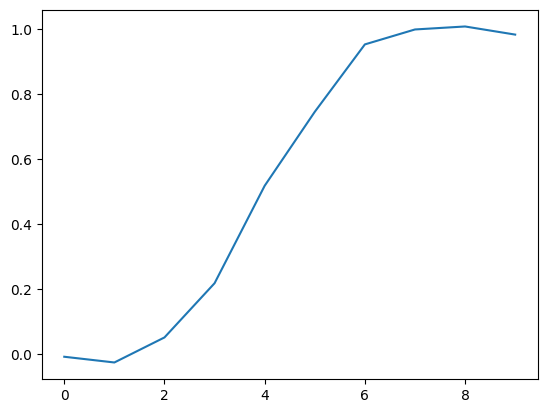

In [192]:
plt.plot(jnp.arange(0,10), jnp.mean(jnp.array(res['posterior']['a'])) + jnp.mean(jnp.array(res['posterior']['k'][0,:,:]), axis = 0))

## Combine latent, random and gaussian

In [485]:
# latent + random = random + latent[village[i]] with village being village ID
# gaussian simulation 
# 1. non linear function to generate gaussian proces for each parameters
# model 2 = random + latent[village[i]] + gaussian_process
# model 3  = model 2 + interaction effect
#interaction effect = non linear function where input is hhmembers[i]*offsets[vilage[i]] with new coefficients params
# Within model we need to change offset ouput as an integer so we do bxi*hhmembers[i]*offset[v_ID[i]]+ bxIsq*(hhmembers[i]*offset[v_ID[i]])
